In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import json
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils

# Read the CSV file, assuming the file path is correct, and read only the columns you need 
# Here is used to obtain the proportion of training, testing and verification data for different identities
df = pd.read_csv('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data/metadata_splits.csv', usecols=['id', 'identity', 'split_open'])

# Divide training, validation, and test data according to the split_open column of the data
train_ids = df[df['split_open'] == 'train']['id'].tolist()
val_ids = df[df['split_open'] == 'valid']['id'].tolist()
test_ids = df[df['split_open'] == 'test']['id'].tolist()

# Load the mask JSON file
with open('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data/annotations.json', 'r') as f:
    mask_annotations = json.load(f)

# 1. Custom data set classes
class TurtleSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_annotations, ids, transform=None, target_transform=None):
        """
        Initialize the dataset class.
        Parameters:
        - img_dir: Directory of image files
        - mask_annotations: JSON data of masks
        - ids: List of image IDs
        - transform: Transformations for images
        - target_transform: Transformations for masks
        """
        self.img_dir = img_dir
        self.mask_annotations = mask_annotations
        self.ids = ids
        self.transform = transform
        self.target_transform = target_transform
        self.image_size = (512, 512)  # Target image size

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        image_id = self.ids[index]
        img_info = next(item for item in self.mask_annotations['images'] if item['id'] == image_id)
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Get mask information and create mask image
        height, width = img_info['height'], img_info['width']
        mask_turtle = np.zeros(self.image_size, dtype=np.uint8)
        mask_flippers = np.zeros(self.image_size, dtype=np.uint8)
        mask_head = np.zeros(self.image_size, dtype=np.uint8)
        annotations = [ann for ann in self.mask_annotations['annotations'] if ann['image_id'] == image_id]
        for ann in annotations:
            category_id = ann['category_id']
            segmentation = ann['segmentation']
            if isinstance(segmentation, dict) and 'counts' in segmentation and isinstance(segmentation['counts'], list):
                # Convert uncompressed RLE to compressed RLE
                rle = maskUtils.frPyObjects([segmentation], height, width)[0]
            else:
                rle = segmentation  # Already in compressed format

            # Decode the segmentation mask (RLE encoded)
            rle_mask = maskUtils.decode(rle)
            rle_mask_resized = np.array(Image.fromarray(rle_mask).resize(self.image_size, Image.NEAREST))
            # Assign each category to the corresponding mask, considering overlap issues
            if category_id == 1:  # Turtle body
                mask_turtle[rle_mask_resized == 1] = 1
            elif category_id == 2:  # Flippers
                mask_flippers[rle_mask_resized == 1] = 2
            elif category_id == 3:  # Head
                mask_head[rle_mask_resized == 1] = 3

        # Merge all masks into the final mask, ensuring overlap parts are handled by priority
        mask = np.maximum(np.maximum(mask_turtle, mask_flippers), mask_head)
        mask = Image.fromarray(mask)

        # Transformations for image and mask
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)*255

        return image, mask


    def decode_rle(rle, size):
        """
        Decode RLE format
        Parameters:
        - rle: RLE encoded mask data
        - size: Size of the mask (height, width)
        Returns:
        - mask: Decoded mask array
        """
        height, width = size
        flat_mask = np.zeros(height * width, dtype=np.uint8)
        index = 0
        for i in range(0, len(rle), 2):
            if i + 1 >= len(rle):
                break
            start = rle[i]
            length = rle[i + 1]
            flat_mask[index + start:index + start + length] = 1
            index += start + length
        return flat_mask.reshape((height, width))


# 2. Data transformations
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# Create dataset instances for training, validation, and testing
train_dataset = TurtleSegmentationDataset('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data', mask_annotations, train_ids,
                                          transform=image_transform, target_transform=mask_transform)
val_dataset = TurtleSegmentationDataset('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data', mask_annotations, val_ids,
                                        transform=image_transform, target_transform=mask_transform)
test_dataset = TurtleSegmentationDataset('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data', mask_annotations, test_ids,
                                         transform=image_transform, target_transform=mask_transform)

# Use DataLoader to load datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)


# Visualize a batch of data
def visualize_batch(loader):
    """
    Visualize a batch of data, including input images and ground truth masks.
    Parameters:
    - loader: DataLoader object used to load the dataset
    """
    for images, masks in loader:
        batch_size = images.size(0)
        for i in range(batch_size):
            plt.figure(figsize=(10, 5))

            # Display image
            plt.subplot(1, 2, 1)
            plt.title('Input Image')
            plt.imshow(images[i].permute(1, 2, 0).numpy())

            # Display mask
            plt.subplot(1, 2, 2)
            plt.title('Ground Truth Mask')
            plt.imshow(masks[i].squeeze().numpy(), cmap='gray')

            plt.show()
        break


In [4]:
# 1.Model Definition and Training Setup
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
import torch.nn.functional as F

# UNet model definition
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.dec4(torch.cat((self.up4(bottleneck), enc4), dim=1))
        dec3 = self.dec3(torch.cat((self.up3(dec4), enc3), dim=1))
        dec2 = self.dec2(torch.cat((self.up2(dec3), enc2), dim=1))
        dec1 = self.dec1(torch.cat((self.up1(dec2), enc1), dim=1))

        return self.out_conv(dec1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the UNet model and set the number of output channels
num_classes = 4
model = UNet(in_channels=3, out_channels=num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to compute mIoU and IoU
def compute_iou(pred, target, num_classes):
    iou_list = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        iou_list.append(iou)
    avg_iou = np.nanmean(iou_list)
    return iou_list, avg_iou

# 2.Train the Model
num_epochs = 25  # Total number of training epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        # Move data to GPU or CPU
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
        masks = masks.view(-1)
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print the average loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # 3.Validation evaluation
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    iou_per_class = np.zeros(num_classes)
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Adjust mask dimensions to fit the requirements of the loss function
            masks = masks.squeeze(1) if masks.ndim == 4 else masks

            outputs = model(images)
            # Adjust the shape of outputs and masks to fit the loss function
            outputs_reshaped = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
            masks_reshaped = masks.view(-1)
            # Compute loss
            loss = criterion(outputs_reshaped, masks_reshaped.long())
            val_loss += loss.item()

            # Compute mIoU and IoU
            iou_list, avg_iou = compute_iou(outputs, masks, num_classes)
            total_iou += avg_iou
            iou_per_class += np.nan_to_num(iou_list)

    # Print the average validation loss, mIoU, and IoU for each class
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = total_iou / len(val_loader)
    iou_per_class /= len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}, mIoU: {avg_iou:.4f}")
    for cls in range(num_classes):
        print(f"IoU for class {cls}: {iou_per_class[cls]:.4f}")

print("Finished！")

# 4.Save the Model
torch.save(model.state_dict(), 'unet_seaturtle_state.pth')


Epoch [1/25], Loss: 0.3114
Validation Loss: 0.2634, mIoU: 0.4220
IoU for class 0: 0.9362
IoU for class 1: 0.4326
IoU for class 2: 0.1958
IoU for class 3: 0.1237
Epoch [2/25], Loss: 0.2267
Validation Loss: 0.2660, mIoU: 0.4781
IoU for class 0: 0.9080
IoU for class 1: 0.4958
IoU for class 2: 0.2849
IoU for class 3: 0.2237
Epoch [3/25], Loss: 0.1901
Validation Loss: 0.1679, mIoU: 0.5803
IoU for class 0: 0.9636
IoU for class 1: 0.5993
IoU for class 2: 0.4128
IoU for class 3: 0.3455
Epoch [4/25], Loss: 0.1588
Validation Loss: 0.1455, mIoU: 0.6479
IoU for class 0: 0.9638
IoU for class 1: 0.6217
IoU for class 2: 0.5225
IoU for class 3: 0.4836
Epoch [5/25], Loss: 0.1336
Validation Loss: 0.1522, mIoU: 0.6382
IoU for class 0: 0.9661
IoU for class 1: 0.6458
IoU for class 2: 0.5537
IoU for class 3: 0.3871
Epoch [6/25], Loss: 0.1125
Validation Loss: 0.0982, mIoU: 0.7126
IoU for class 0: 0.9787
IoU for class 1: 0.7195
IoU for class 2: 0.5640
IoU for class 3: 0.5884
Epoch [7/25], Loss: 0.0947
Validat

In [5]:
# 1.Test the Model
# Load the model for testing
model = UNet(in_channels=3, out_channels=num_classes)
state_dict = torch.load('unet_seaturtle_state.pth')
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# 2.Evaluate the test set
test_loss = 0.0
total_iou = 0.0
iou_per_class = np.zeros(num_classes)
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        # Adjust the shape of outputs and masks to fit the loss function
        outputs_reshaped = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
        masks_reshaped = masks.view(-1)
        # Compute loss
        loss = criterion(outputs_reshaped, masks_reshaped.long())
        test_loss += loss.item()

        # Compute mIoU and IoU
        iou_list, avg_iou = compute_iou(outputs, masks, num_classes)
        total_iou += avg_iou
        iou_per_class += np.nan_to_num(iou_list)

# Print the average test loss, mIoU, and IoU for each class
avg_test_loss = test_loss / len(test_loader)
avg_test_iou = total_iou / len(test_loader)
iou_per_class /= len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}, mIoU: {avg_test_iou:.4f}")
for cls in range(num_classes):
    print(f"IoU for class {cls}: {iou_per_class[cls]:.4f}")


<ipython-input-5-0fac5d29da63>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('unet_seaturtle_state.pth')


Test Loss: 0.0485, mIoU: 0.3836
IoU for class 0: 0.8772
IoU for class 1: 0.3015
IoU for class 2: 0.1670
IoU for class 3: 0.1888


Successful Segmentation:


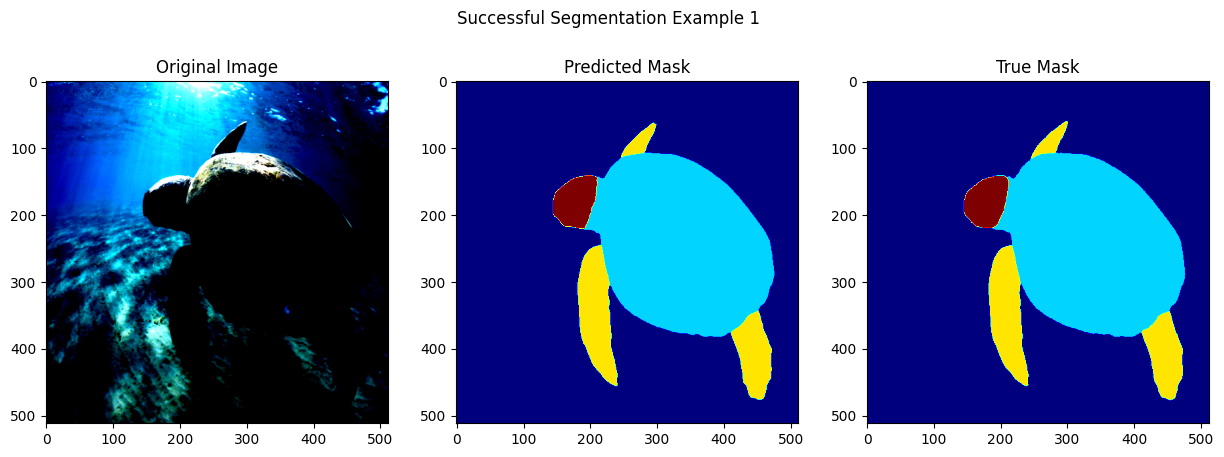

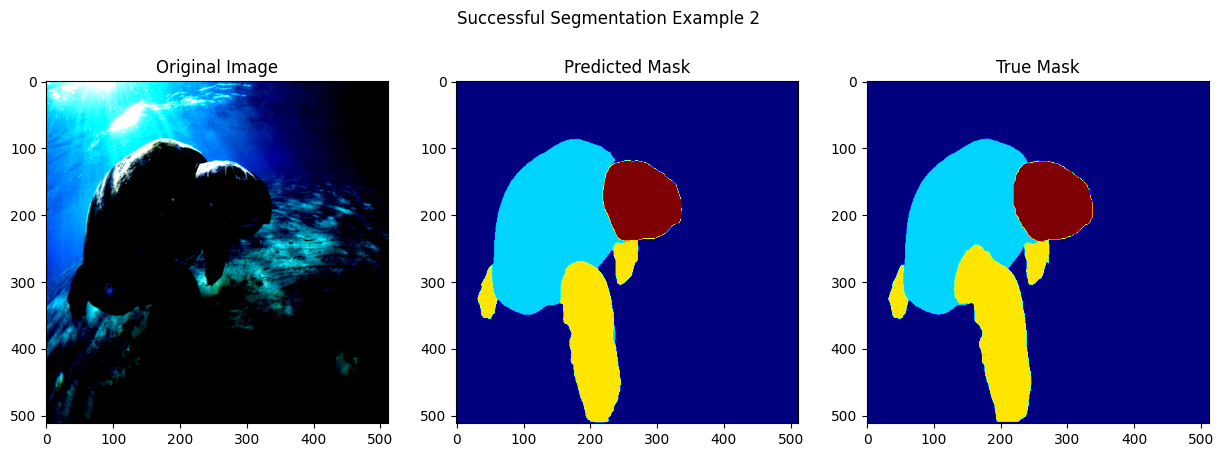

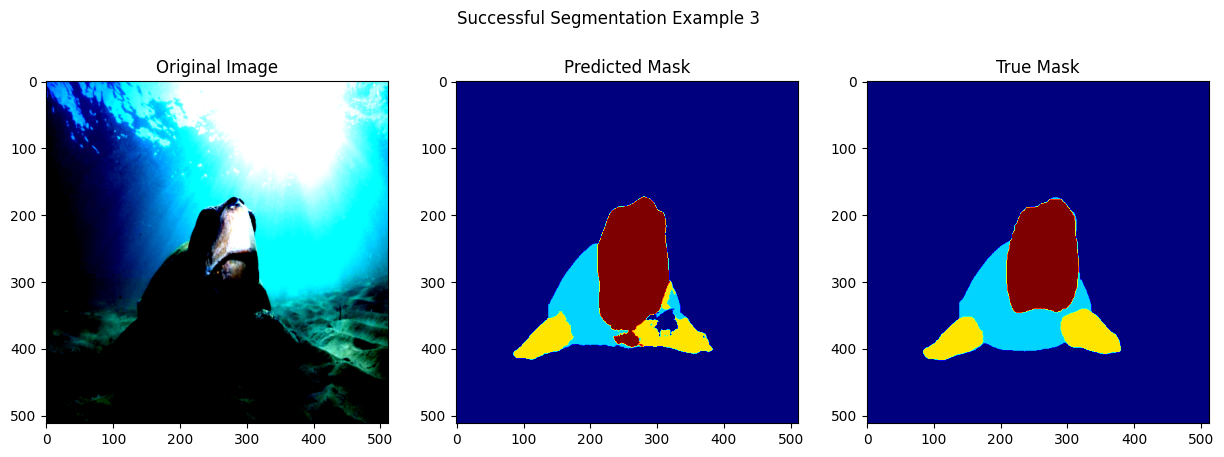

Failed Segmentation:


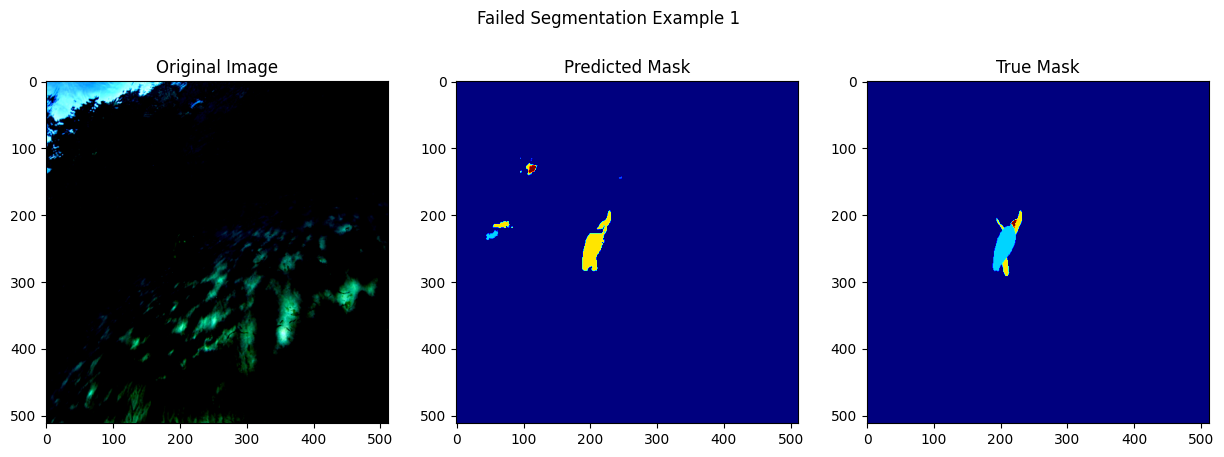

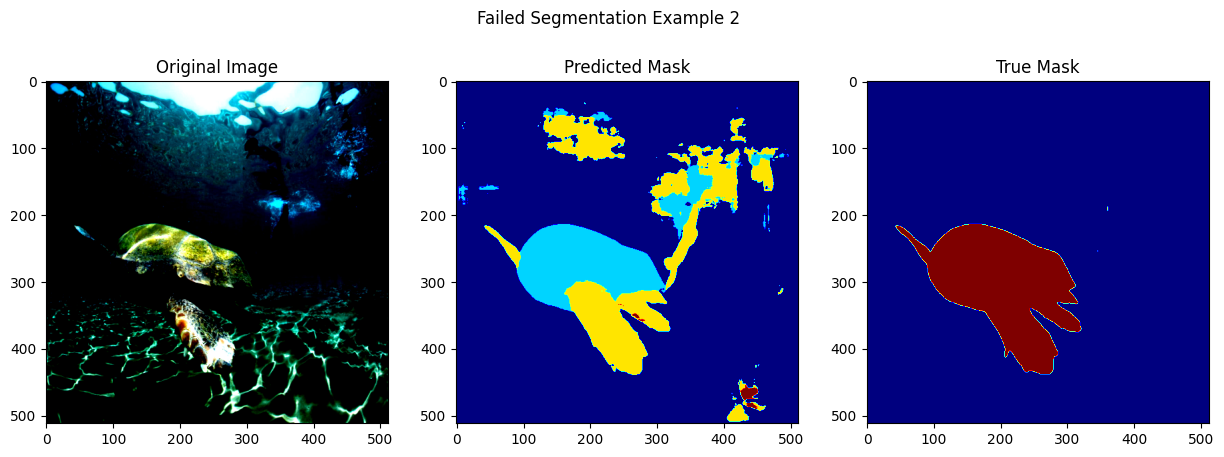

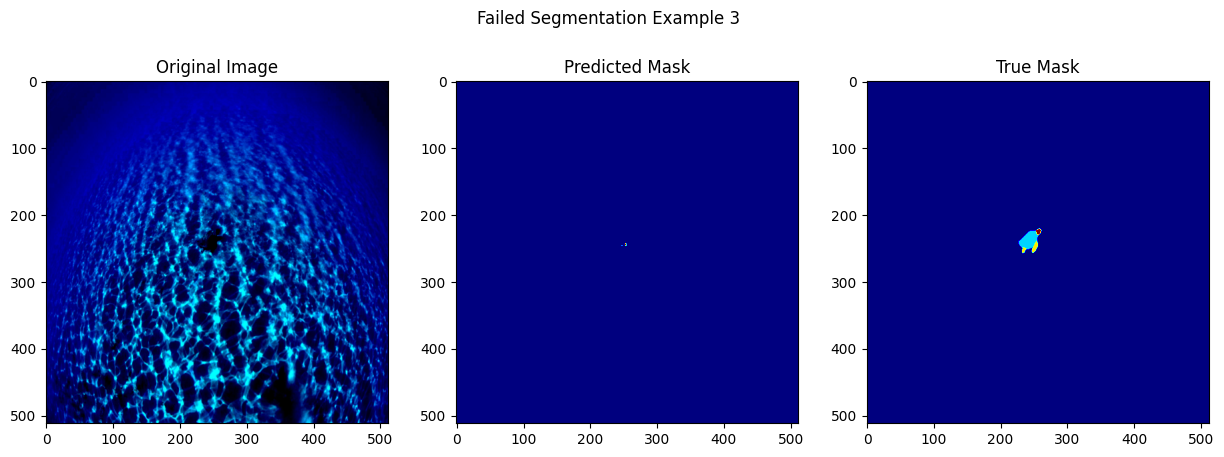

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Lists to store examples of success and failure
success_cases = []
failure_cases = []

iou_success_threshold = 0.7
iou_failure_threshold = 0.3

# Evaluate the test set
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        # Save examples of success and failure
        predicted_masks = torch.argmax(outputs, dim=1)
        for i in range(images.size(0)):
            iou_list, avg_iou = compute_iou(outputs[i].unsqueeze(0), masks[i].unsqueeze(0), num_classes)
            if avg_iou >= iou_success_threshold:
                success_cases.append((images[i].cpu(), predicted_masks[i].cpu(), masks[i].cpu()))
            elif avg_iou <= iou_failure_threshold:
                failure_cases.append((images[i].cpu(), predicted_masks[i].cpu(), masks[i].cpu()))


def visualize_examples(examples, title):
    for idx, (image, predicted_mask, true_mask) in enumerate(examples):
        if idx >= 3:
            break

        # Check the shape of the image and handle single or multiple channels
        if image.shape[0] == 1:
            image_np = image.squeeze(0).numpy()
        elif image.shape[0] == 3:
            image_np = image.permute(1, 2, 0).numpy()
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")

        # Process predicted and true masks
        predicted_mask_np = predicted_mask.squeeze().numpy().astype(np.int32)
        true_mask_np = true_mask.squeeze().numpy().astype(np.int32)

        # Create a subplot to show the original image, predicted mask, and true mask
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Display the original image
        if image_np.ndim == 2:
            axs[0].imshow(image_np, cmap='gray')
        else:
            axs[0].imshow(image_np)
        axs[0].set_title("Original Image")

        # Display the predicted mask and true mask
        axs[1].imshow(predicted_mask_np, cmap='jet')
        axs[1].set_title("Predicted Mask")
        axs[2].imshow(true_mask_np, cmap='jet')
        axs[2].set_title("True Mask")

        fig.suptitle(f"{title} Example {idx + 1}")
        plt.show()

# Visualize success and failure cases
print("Successful Segmentation:")
visualize_examples(success_cases, "Successful Segmentation")

print("Failed Segmentation:")
visualize_examples(failure_cases, "Failed Segmentation")
